In [1]:
import pandas as pd
import numpy as np

temp_df = pd.read_csv("C:\\Users\\Лев\\Projects\\Diploma\\sbp2.csv", sep=';')
temp_df['time'] = pd.to_datetime(temp_df['time'], dayfirst=True)
temp_df = temp_df.sort_values(by=['time'])
temp = pd.DataFrame(pd.date_range(start=temp_df['time'][55215], end=temp_df['time'][0], freq='3 h'), columns=['time'])
temp = temp.set_index('time').join(temp_df.set_index('time'), how='left')
temp = temp['T'].ffill().to_frame()
temp.index = pd.date_range(start=temp_df['time'][55215], end=temp_df['time'][0], freq='3 h')

from sktime.forecasting.model_selection import temporal_train_test_split

temp_train, temp_test = temp.values[:-2920].reshape(1, -1)[0], temp.values[2920:].reshape(1, -1)[0]

In [ ]:
X_train = np.array([diffs_train[i:i+13] for i in range(0, 52480, 3)])
Y_train = np.array([diffs_train[i+13] for i in range(0, 52480, 3)])
X_test = np.array([diffs_test[i:i+13] for i in range(0, 2907, 3)])
Y_test = np.array([diffs_test[i+13] for i in range(0, 2907, 3)])

In [ ]:
X_train = np.array([temp_train[i:i+13] for i in range(0, 52470, 3)])
Y_train = np.array([temp_train[i+13] for i in range(0, 52470, 3)])
X_test = np.array([temp_test[i:i+13] for i in range(0, 2905, 3)])
Y_test = np.array([temp_test[i+13] for i in range(0, 2905, 3)])

In [ ]:
from sklearn.ensemble import RandomForestRegressor

regr = RandomForestRegressor(n_estimators = 200,
                             n_jobs=-1)
regr.fit(X_train, Y_train)

RandomForestRegressor(n_estimators=200, n_jobs=-1)

In [2]:
def l2_improved(y_true, y_pred, indexes):
    if len(y_pred) != len(y_true):
        print("Lenghts are not the same!")
        return 0
    hour_vars = {0:     0.831691, 
                 3:     1.450059,
                 6:	    1.757970,
                 9:	    0.475864,
                 12:    0.629008,
                 15:	0.960935,
                 18:	1.110826,
                 21:	0.783646}
    s = 0
    n = len(y_true)
    for i in range(n):
        s += (y_true[i] - y_pred[i]) ** 2 * hour_vars[indexes[i]]
    return np.sqrt(s / n) 

In [ ]:
regr.predict(X_test)

array([ 0.44384307,  0.86931311, -0.45232718, ..., -0.9869254 ,
       -0.02730396, -0.13373904])

In [ ]:
l2_improved(regr.predict(X_test), Y_test, 0)

In [ ]:
from sklearn.ensemble import RandomForestRegressor

for k in [7, 15, 23, 31, 63]:
    X_train = np.array([diffs_train[i:i+k] for i in range(0, 52492-k, 3)])
    Y_train = np.array([diffs_train[i+k] for i in range(0, 52492-k, 3)])
    X_test = np.array([diffs_test[i:i+k] for i in range(0, 2919-k, 1)])
    Y_test = np.array([diffs_test[i+k] for i in range(0, 2919-k, 1)])

    print(f"Обучение модели для k={k}...")
    regr = RandomForestRegressor(n_estimators = 100,
                             n_jobs=-1)
    regr.fit(X_train, Y_train)
    print(f"Полученная метрика: {l2_improved(regr.predict(X_test), Y_test, [(x % 8) * 3 for x in list(range(k, 2919))])}", end='\n\n')

In [ ]:
from sklearn.ensemble import RandomForestRegressor

for k in [7, 15, 23, 31, 63]:
    X_train = np.array([temp_train[i:i+k] for i in range(0, 52492-k, 3)])
    Y_train = np.array([temp_train[i+k] for i in range(0, 52492-k, 3)])
    X_test = np.array([temp_test[i:i+k] for i in range(0, 2919-k, 1)])
    Y_test = np.array([temp_test[i+k] for i in range(0, 2919-k, 1)])

    print(f"Обучение модели для k={k}...")
    regr = RandomForestRegressor(n_estimators = 100,
                             n_jobs=-1)
    regr.fit(X_train, Y_train)
    print(f"Полученная метрика: {l2_improved(regr.predict(X_test), Y_test, [(x % 8) * 3 for x in list(range(k, 2919))])}", end='\n\n')

Обучение модели для k=7...
Полученная метрика: 1.2226864296914306

Обучение модели для k=15...
Полученная метрика: 1.1934284017224823

Обучение модели для k=23...
Полученная метрика: 1.1927611678100005

Обучение модели для k=31...
Полученная метрика: 1.1657380737267948

Обучение модели для k=63...
Полученная метрика: 1.1911964615600168



In [4]:
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt

errors2d = []
for k in [7, 15, 31, 63]:
    X_train = np.array([temp_train[i:i+k] for i in range(0, 52450-k, 3)])
    Y_train = np.array([temp_train[i+k] for i in range(0, 52450-k, 3)])
    X_test = np.array([temp_test[i:i+k] for i in range(0, 2890-k, 1)])
    Y_test = np.array([temp_test[i+k] for i in range(0, 2890-k, 1)])

    print(f"Обучение модели для k={k}...")
    regr = RandomForestRegressor(n_estimators = 100,
                                n_jobs=-1)
    regr.fit(X_train, Y_train)
    errors = []

    for j in range(24):
        result = regr.predict(X_test)
        errors.append(l2_improved(result, Y_test, [((x + j) % 8) * 3 for x in list(range(k, 2890))]))

        X_test = np.concatenate((X_test[:,1:], result.reshape(-1, 1)), axis=1)
        Y_test = np.array([temp_test[i+k] for i in range(j + 1, 2891+j-k, 1)])
    
    errors2d.append(errors)

Обучение модели для k=7...
Обучение модели для k=15...
Обучение модели для k=31...
Обучение модели для k=63...


In [5]:
errors_arima = [1.3648835928739165, 2.1035506856498496, 2.537050965478064, 2.7212447140235474, 2.8866002234543053, 3.076821962631482, 3.1759682281117727, 3.3263500752832975, 3.572915794746735, 3.7152302234394994, 3.856319719449047, 4.14786543760261, 3.98814916662553, 3.8205142676643224, 4.113673670867024, 4.235502299123145, 4.325594985614661, 4.364605765604793, 4.5109944300821185, 4.662437254969248, 4.6786682879444115, 4.423366145483313, 4.565969660006295, 4.839871317764217]
errors_naive = [1.4397780182050635, 2.3083268163831785, 3.0005590439356684, 3.4464083445843094, 3.5343083326293887, 3.450806992828847, 3.3459484850706747, 3.402772319273203, 3.6361483346044765, 3.948508871997673, 4.298853263008481, 4.5630259197489895, 4.615051857565328, 4.55103620640407, 4.479715994589277, 4.512580692266964, 4.634599339409483, 4.817826161745919, 5.058715571267133, 5.256200029814936, 5.262736502585181, 5.18633236475787, 5.0960702480490525, 5.10072170495821]

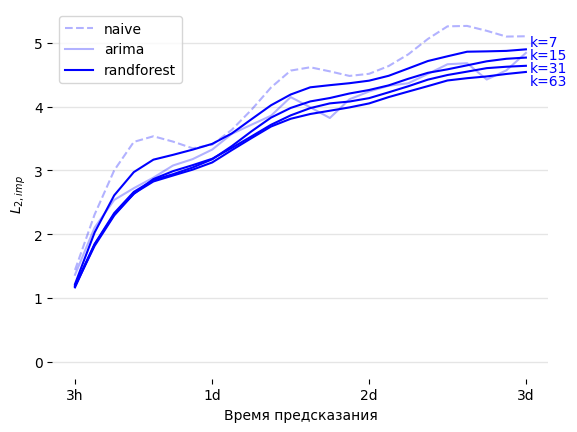

In [15]:
x_values = list(range(24))
names=['3h','6h','               ','12h','              ','18h','             ','1d','            ','           ','          ','1d12h','         ','        ','       ','2d', ' ','  ','   ','2d12h','    ','     ','      ','3d']

plt.box(False)
for h in range(6):
    plt.axhline(y=h, color='black', alpha=0.1, lw=1)

plt.plot(x_values, errors_naive, color="blue", alpha=0.3, label="naive", ls="--")
plt.plot(x_values, errors_arima, color="blue", alpha=0.3, label="arima")
plt.plot(x_values, errors2d[0], color="blue",label="randforest")
plt.plot(x_values, errors2d[1], color="blue")
plt.plot(x_values, errors2d[2], color="blue")
plt.plot(x_values, errors2d[3], color="blue")
plt.text(23.2, 4.94, "k=7", color='blue')
plt.text(23.2, 4.74, "k=15", color='blue')
plt.text(23.2, 4.54, "k=31", color='blue')
plt.text(23.2, 4.34, "k=63", color='blue')
plt.xticks(x_values, names)
plt.xticks([0,7,15,23])
plt.xlabel("Время предсказания")
plt.ylabel("$L_{2,imp}$")
plt.legend()
plt.show()
